<a href="https://colab.research.google.com/github/fleckc/visSP23/blob/main/ps6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import pandas as pd
import numpy as np
import urllib
import os
from google.colab import files
import time, os, sys, re
import pandas_datareader as pdr
from pandas_datareader import wb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('default')

#Data
This dataset is the 2021 New Jersey state legislative primaries results, along with other possibly important variables such as gender, a campaign finance report, and party. Candidates are the unit of observation, but broken up by county; since the goal is to look at county party endorsedments, these are separated out. Thus there are multiple observations for a candidate if their legislative district covered more than one county.

The main question to be asked in a regression is whether there is an effect from the endorsement process on the margin of victory in which that candidate was endorsed. But generally, we are looking to see if the endorsement is valuable in some way.

In [3]:
njline = pd.read_csv("https://github.com/fleckc/visSP23/raw/main/njline.csv")

In [4]:
njline['Year'].astype(str)
njline21 = njline[njline['Year'] == 2021] #subsetting by year - incomplete data for 2019/going forward (yet!)

In [5]:
partycolor = ["red", "blue"]
#will use for party color palette in graphs to distinguish between candidates of different parties

In [6]:
njline21cf = njline21.drop_duplicates(subset='Candidate') #isolate individual candidates to avoid duplicates for campaign finance analysis

In [34]:
njline21out = njline[(njline['Margin.of.Victory.County'] > 0) & (njline['Endorsement'] == 0)] #creating subset of vote outliers
njline21out2 = njline[(njline['Endorsement'] == 0) & (njline['Party'] == "R") & (njline['Eleven.Day.COH'] > 80000)] #creating finance outliers
njline21out3 = njline[(njline['Endorsement'] == 1) & (njline['Party'] == "R") & (njline['Eleven.Day.COH'] > 80000)] #creating finance outliers

In [40]:
njline21out

,Year,Candidate,Party,LD,Level,Gender,Incumbent,County,Endorsement,Votes.Received,Nearest.Comp,Total.County.Votes,Margin.of.Victory.County,Eleven.Day.COH,Treatment
44,2021,Webber,R,26,A,M,1,Passaic,0,1001,642,2935,0.122317,104384.34,1.0
52,2021,Webber,R,26,A,M,1,Essex,0,1192,721,3507,0.134303,104384.34,1.0


In [32]:
njline21out2

,Year,Candidate,Party,LD,Level,Gender,Incumbent,County,Endorsement,Votes.Received,Nearest.Comp,Total.County.Votes,Margin.of.Victory.County,Eleven.Day.COH,Treatment
44,2021,Webber,R,26,A,M,1,Passaic,0,1001,642,2935,0.122317,104384.34,1.0
52,2021,Webber,R,26,A,M,1,Essex,0,1192,721,3507,0.134303,104384.34,1.0
94,2021,Cruz,R,24,S,M,0,Morris,0,226,1105,1331,-0.660406,88980.92,0.0


In [36]:
njline21out3

,Year,Candidate,Party,LD,Level,Gender,Incumbent,County,Endorsement,Votes.Received,Nearest.Comp,Total.County.Votes,Margin.of.Victory.County,Eleven.Day.COH,Treatment
4,2021,Dancer,R,12,A,M,1,Burlington,1,685,43,1355,0.473801,253530.77,0.0
7,2021,Dancer,R,12,A,M,1,Middlesex,1,1453,75,2972,0.463661,253530.77,0.0
10,2021,Dancer,R,12,A,M,1,Monmouth,1,3148,210,6459,0.454869,253530.77,0.0
13,2021,Dancer,R,12,A,M,1,Ocean,1,3424,209,6888,0.466754,253530.77,0.0
48,2021,Webber,R,26,A,M,1,Morris,1,7775,4656,22497,0.138641,104384.34,1.0
69,2021,Polistina,R,2,S,M,0,Atlantic,1,6331,2752,9083,0.394033,112827.15,0.0
93,2021,Oroho,R,24,S,M,1,Morris,1,1105,226,1331,0.660406,88980.92,0.0
95,2021,Oroho,R,24,S,M,1,Sussex,1,10404,2003,12407,0.677118,88980.92,0.0


#Figure - Endorsements, in General



Let's look at the difference between endorsed candidates and challenger candidates, with a distinction by party as well.

<ipython-input-68-597ee9ccb33c>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Challenger', 'Endorsed'])


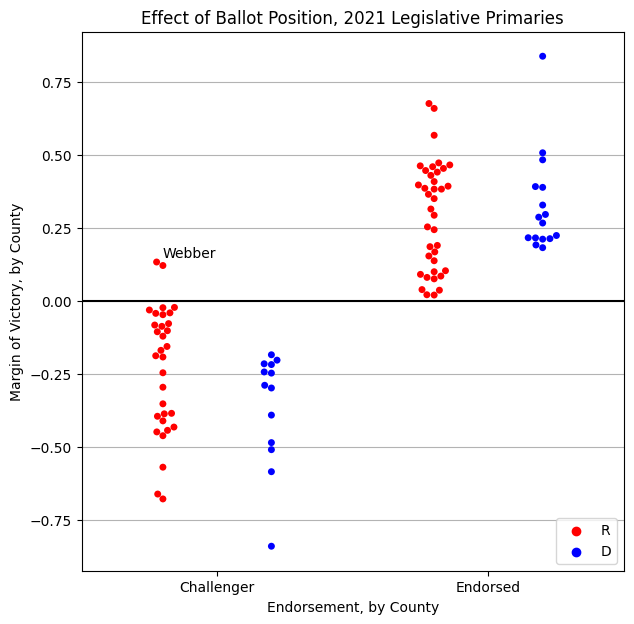

In [68]:
from matplotlib import markers
fig, ax = plt.subplots(figsize = (7,7))
sns.set_palette(partycolor)
ax = sns.swarmplot(x='Endorsement',y='Margin.of.Victory.County', data = njline21, hue = 'Party', dodge = True)
ax.set(xlabel = "Endorsement, by County", ylabel = "Margin of Victory, by County", title = "Effect of Ballot Position, 2021 Legislative Primaries")
plt.grid(axis='y', color='.7')
ax.axhline(0.0, color = "black") #who wins and loses is determined by this line!
ax.set_xticklabels(['Challenger', 'Endorsed'])
plt.text(-.2,.15, 'Webber') #better than ax annotate
plt.legend(loc = 'lower right')
plt.show();

We have a great view of our main question. The most important question is who are the outliers that have been demonstrated. In this case, it is the two unendorsed candidate-county observations with a positive margin of victory.

There is one candidate (in two counties of their district) who was not the endorsed candidate and did win that county. So we have a finding!

Additionally, by sorting the candidate observations by party and separating them, we can see there is a greater effect for Democrats than Republicans.

##Figure - Endorsements by Incumbency

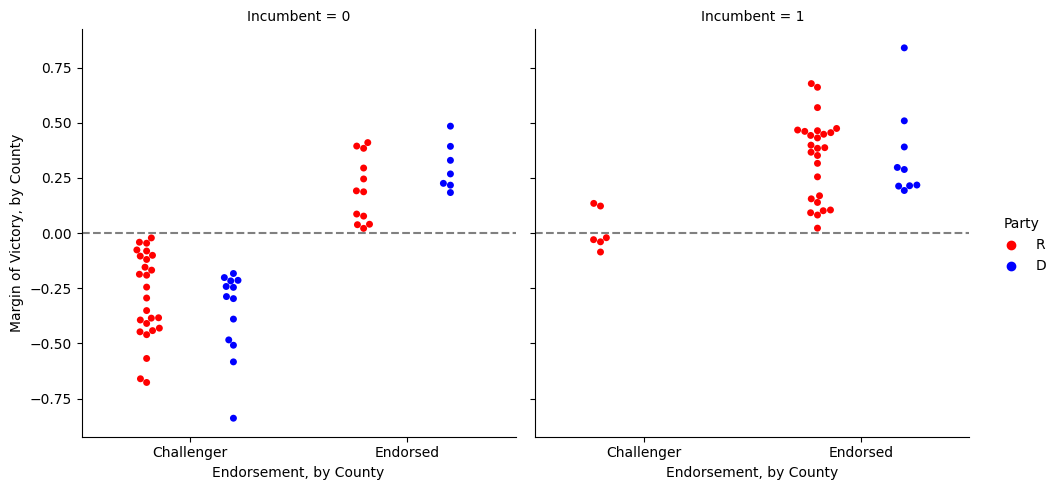

In [107]:
ax = sns.catplot(x='Endorsement',y='Margin.of.Victory.County', data = njline21, hue = 'Party', col = 'Incumbent', kind = 'swarm', dodge = True, sharex = True)
ax.set_xticklabels(['Challenger', 'Endorsed'])
ax.set_ylabels('Margin of Victory, by County')
ax.set_xlabels('Endorsement, by County')
ax.refline(y=0)
#ax.set_titles("Newcomers", "Incumbents") #can't seem to get the titles correct
plt.show();

Here is a separation of the data by incumbency. Interestingly, Democrats did not have competitive primaries with incumbents that had been denied the endorsement. Again we see the Webber outlier, as they were an incumbent who was successful against the endorsed candidate in those counties.

# Figure - Number of Candidates

<ipython-input-25-848e548bdc26>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Assembly', 'Senate'])


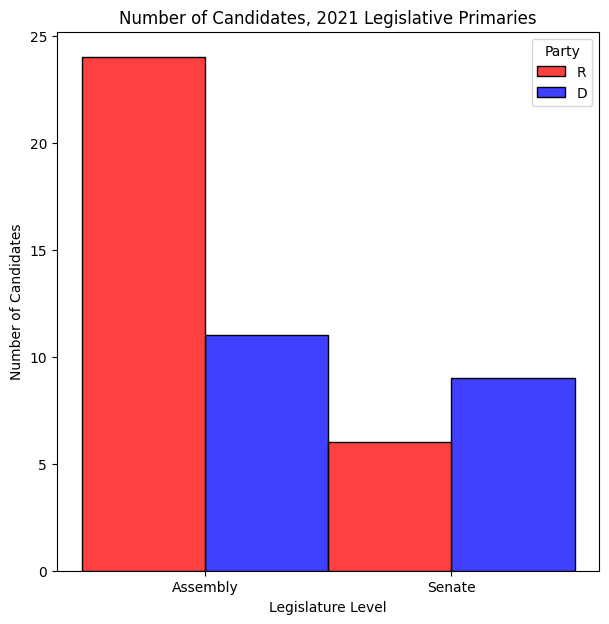

In [25]:
f, ax = plt.subplots(figsize=(7, 7))
sns.histplot(x="Level", hue="Party", multiple = "dodge", data = njline21cf)
ax.set_xticklabels(['Assembly', 'Senate'])
ax.set(xlabel = "Legislature Level", ylabel = "Number of Candidates", title = "Number of Candidates, 2021 Legislative Primaries")
plt.show();

There are a lot more observations of Republican candidates in the Assembly; there were more competitive primaries in that house of the legislature.

#Figure - Campaign Finance

Let's look at how much money these campaigns have at the last report before the primary election date. This is an attempt to look at the value of the endorsement, or the power of a particular candidate.

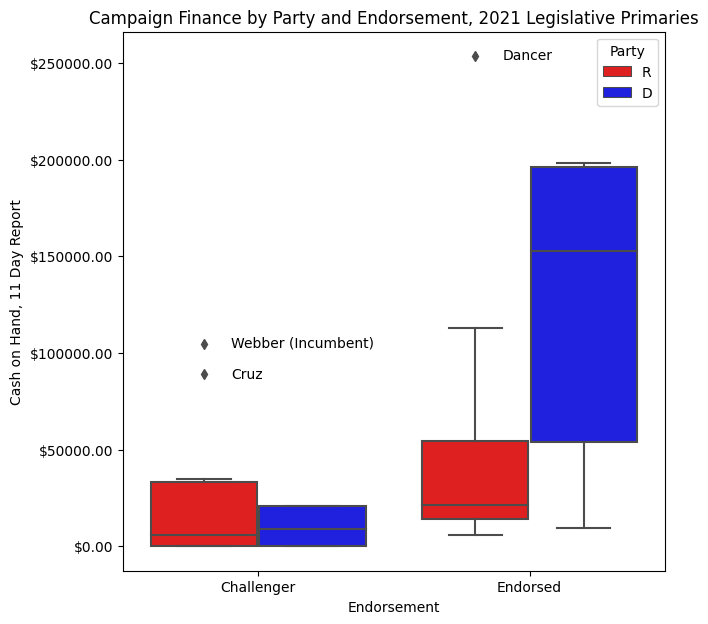

In [50]:
fig, ax = plt.subplots(figsize = (7,7))
sns.set_palette(partycolor)
sns.boxplot(x = "Endorsement", y = "Eleven.Day.COH", data = njline21cf, hue = "Party")
ax.set(xlabel = "Endorsement", ylabel = "Cash on Hand, 11 Day Report", title = "Campaign Finance by Party and Endorsement, 2021 Legislative Primaries")
ax.set_xticklabels(['Challenger', 'Endorsed'])
ax.yaxis.set_major_formatter('${x:1.2f}')
plt.text(-.1,103000, 'Webber')
plt.text(-.1,87000, 'Cruz')
plt.text(0.9, 251900, 'Dancer')
plt.show();

There is a distinct difference in the endorsed candidates against the undendorsed candidates, but the difference is even more stark when separated by party. Though there is a Republican outlier, most endorsed Democrats in the legislative elections have a lot more money than both their primary election opponents as well as the opposing party. New Jersey is predominantly a blue state, but given that state legislative districts must be similar in population size, that may not be a possible explanation. Is there simply more money in the Democratic party?

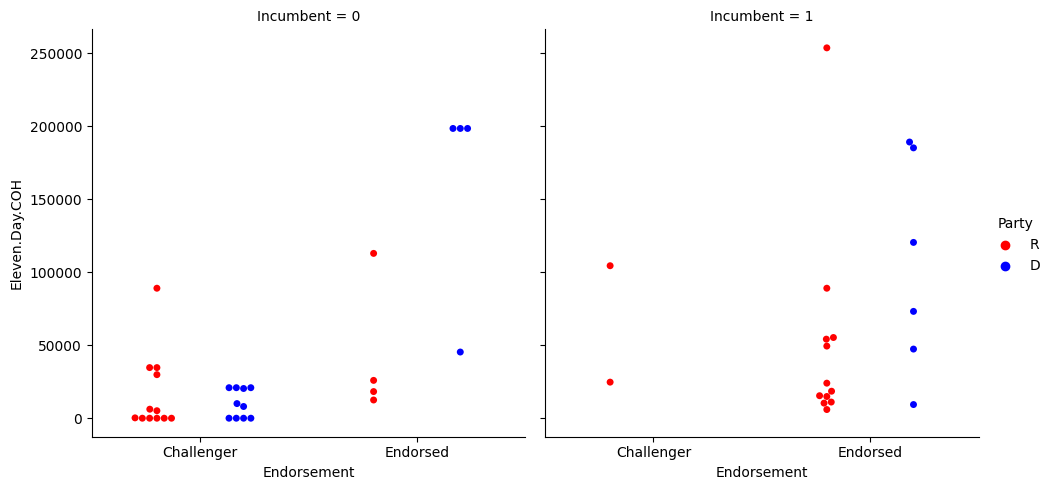

In [113]:
ax = sns.catplot(x='Endorsement',y='Eleven.Day.COH', data = njline21cf, hue = 'Party', col = 'Incumbent', kind = 'swarm', dodge = True)
ax.set_xticklabels(['Challenger', 'Endorsed'])
#ax.set_ylabels('Margin of Victory, by County')
#ax.set_xlabels('Endorsement, by County')
#ax.refline(y=0)
#ax.set_titles("Newcomers", "Incumbents") #can't seem to get the titles correct
plt.show();

#Conclusions So Far

Clearly, there is some relationship between the endorsement process and success in the primary. As well, we see a relationship between endorsement status and campaign financing. These two relationships form the crux of the investigation: what exactly does a party endorsement confer when it is given? It seems that there is quite a lot, both monetarily as well as electorally.